This notebook explores the relationship between **Stess Level** and **Daily Screen Time**, **Night Usage**, These 2 features have been chosen based on evaluation of correlations. The code explores this relationship using 4 different regression models.

# Import necessary libraries

In [126]:
#Import matplotlib for plotting
import matplotlib.pyplot as plt

In [127]:
#Import numpy for matrix algebra
import numpy as np

In [128]:
#Import sklearn for machine learning models
from sklearn import datasets
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

In [129]:
#Imprt pandas for Dataset operations
import pandas as pd

In [130]:
#Imprt seaborn for plotting (heatmap, scatter, pairplot)
import seaborn as sns

In [131]:
# Import Scipy to apply Point Biserial Coorelation
from scipy.stats import pointbiserialr

# Load dataset and get a summary of the data for inspection

In [132]:
df = pd.read_csv('mobile_usage_analysis.csv')

In [133]:
#Get a summary of the data
print(df.info())
print(df.describe())
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13589 entries, 0 to 13588
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Unnamed: 0            13589 non-null  int64  
 1   daily_screen_time     13589 non-null  float64
 2   app_sessions          13589 non-null  int64  
 3   notifications_number  13589 non-null  int64  
 4   night_usage           13589 non-null  float64
 5   age                   13589 non-null  int64  
 6   productivity_hours    13589 non-null  float64
 7   stress_level          13589 non-null  float64
 8   apps_installed        13589 non-null  int64  
 9   addicted              13589 non-null  object 
dtypes: float64(4), int64(5), object(1)
memory usage: 1.0+ MB
None
         Unnamed: 0  daily_screen_time  app_sessions  notifications_number  \
count  13589.000000       13589.000000  13589.000000          13589.000000   
mean    6794.000000           7.993782     30.037604    

# Explore Relationships and Correlations

In [134]:
df.drop('Unnamed: 0', axis = 1, inplace = True)
df.drop('addicted', axis = 1, inplace = True)

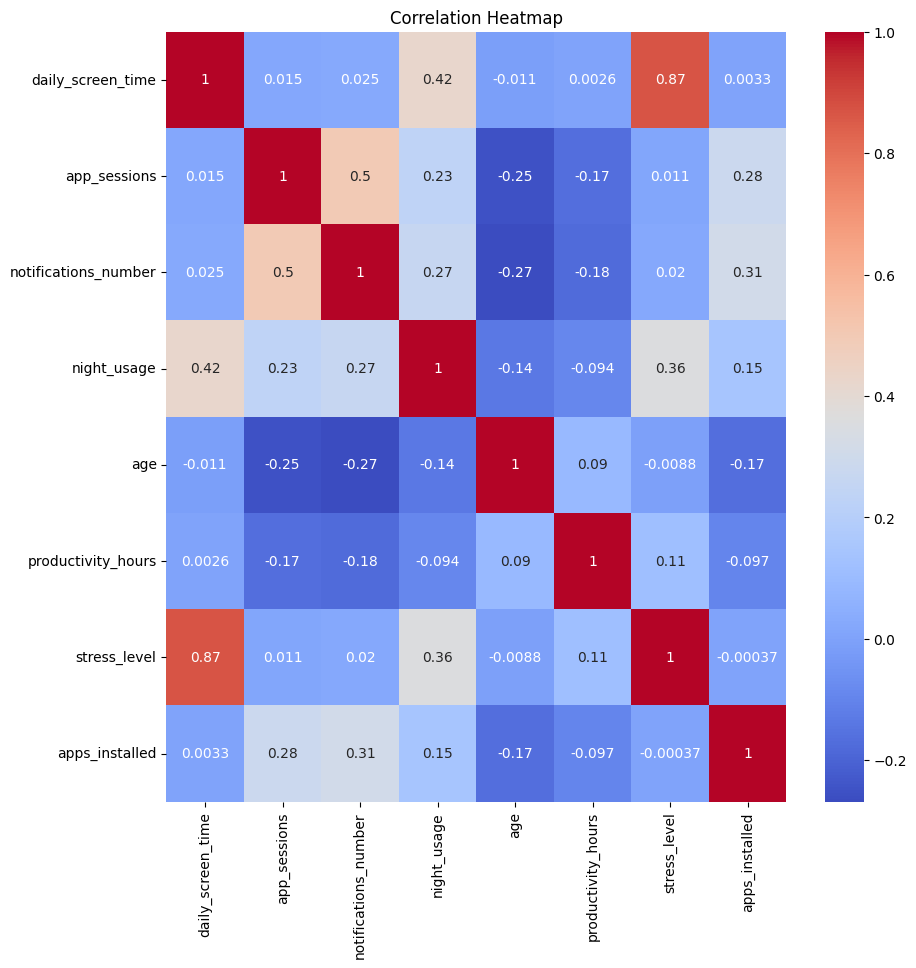

In [135]:
#Correlation matrix
corr = df.corr()

plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

In [136]:
# Create stress level bins
df['stress_level_range'] = pd.cut(df['stress_level'],
                                  bins=[0, 20, 40, 60, 80, 100],
                                  labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

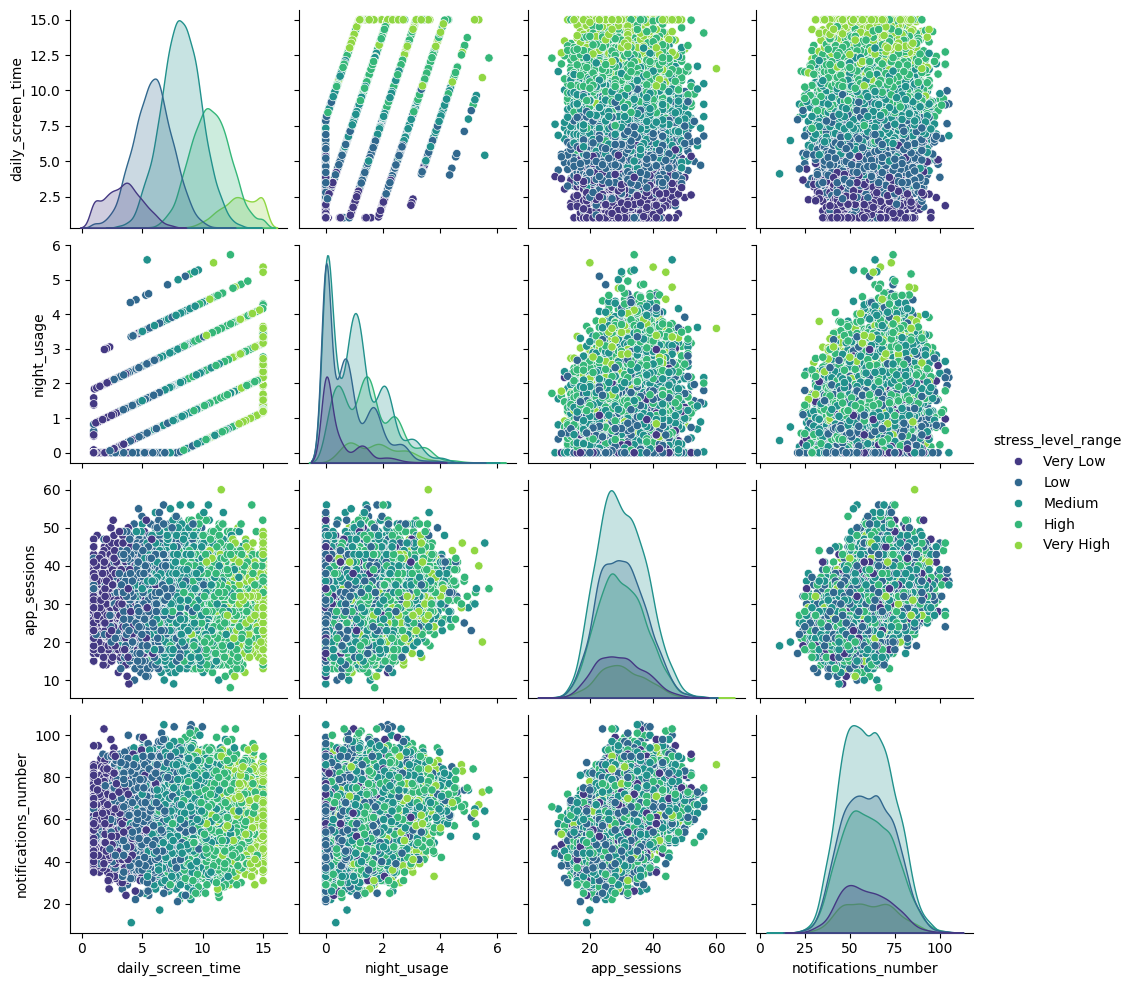

In [137]:
sns.pairplot(df,
             vars=['daily_screen_time', 'night_usage', 'app_sessions', 'notifications_number'],
             hue='stress_level_range',
             palette='viridis')
plt.show()

# Prepare the Data (Splitting, Scalling)

Create models that studies the features that affect "stress_level"

In [138]:
# Select the features based on correlation heatmap
selected_features = ['daily_screen_time', 'night_usage']

X = df[selected_features]
y = df['stress_level']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Regression Models (Multiple LR, Lasso, Polynomial, Random Forest)

Linear Regression Model

In [139]:
# LR Model
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predictions
lr_pred = lr.predict(X_test_scaled)

lr_mse = mean_squared_error(y_test, lr_pred)
lr_rmse = lr_mse ** 0.5 # RMSE (manually)

Lasso Regression Model (Regularized Linear Model)

In [140]:
# Create a Lasso Regression model with alpha = 0.1
ls = Lasso(alpha=0.1)

# Fit the model on scaled data
ls.fit(X_train_scaled, y_train)

ls_predict = ls.predict(X_test_scaled)
ls_mse = mean_squared_error(y_test, ls_predict)
ls_rmse = ls_mse ** 0.5

Polynomial Model

In [141]:
# Create polynomial features
poly_features = PolynomialFeatures(degree=2)
x_poly_train = poly_features.fit_transform(X_train_scaled)
x_poly_test = poly_features.fit_transform(X_test_scaled)


# Fit polynomial regression model
poly = LinearRegression()
poly.fit(x_poly_train, y_train)

# Predict y values on test data using the model
y_pred_test = poly.predict(x_poly_test)

poly_test_mse = mean_squared_error(y_test, y_pred_test)
poly_test_rmse = poly_test_mse ** 0.5

# Predict y values on train data using the model
y_pred_train = poly.predict(x_poly_train)

poly_train_mse = mean_squared_error(y_train, y_pred_train)
poly_train_rmse = poly_train_mse ** 0.5

Randon Forest Regression

In [142]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Tree models don't need scaling

rf_pred = rf.predict(X_test)

rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = rf_mse ** 0.5

# Evaluate Models

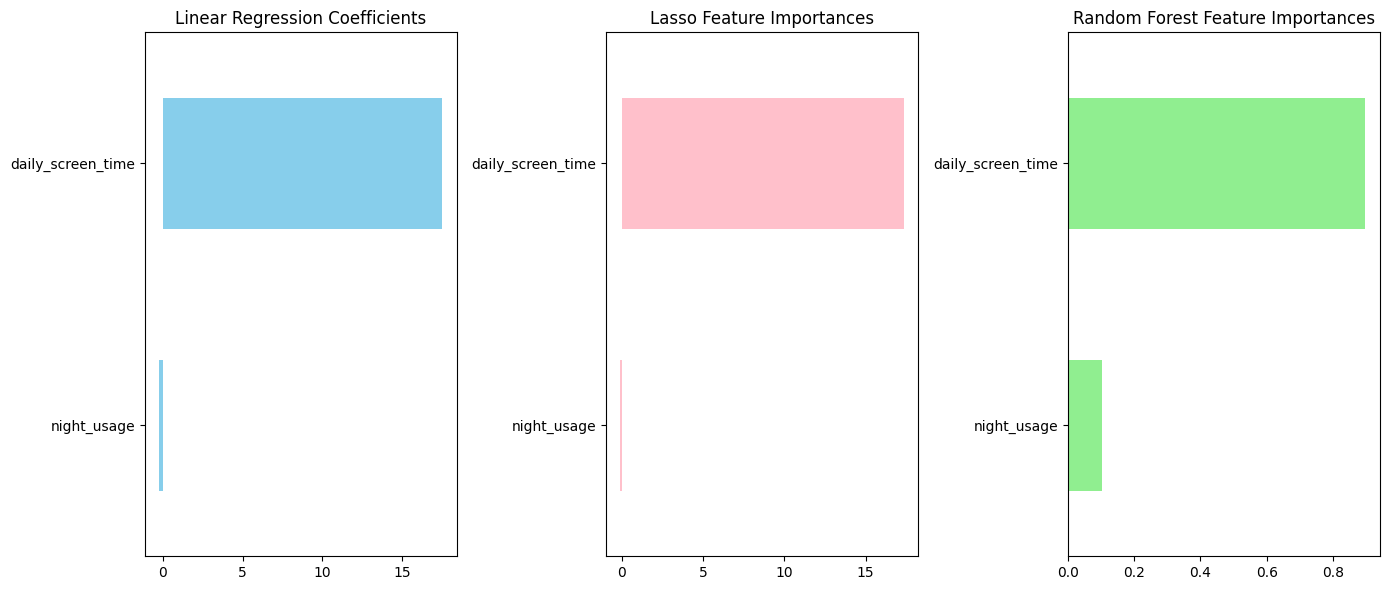

In [143]:
# Feature Importance - Linear Regression Coefficients
lr_coeffs = pd.Series(lr.coef_, index=selected_features).sort_values()

# Feature Importance - Lasso coefficients
lasso_coeffs = pd.Series(ls.coef_, index=selected_features).sort_values()

# Feature Importance - Random Forest
rf_importances = pd.Series(rf.feature_importances_, index=selected_features).sort_values()

# Plot comparison
fig, axes = plt.subplots(1, 3, figsize=(14, 6))

lr_coeffs.plot(kind='barh', ax=axes[0], color='skyblue')
axes[0].set_title('Linear Regression Coefficients')

lasso_coeffs.plot(kind='barh', ax=axes[1], color='pink')
axes[1].set_title('Lasso Feature Importances')

rf_importances.plot(kind='barh', ax=axes[2], color='lightgreen')
axes[2].set_title('Random Forest Feature Importances')

plt.tight_layout()
plt.show()


In [144]:
# Models Evaluation
# LR
print('Linear Regression R²:', r2_score(y_test, lr_pred))
print('Linear Regression MSE:', lr_mse)
print('Linear Regression RMSE:', lr_rmse)
print('\n')

# Lasso (alpha = 2)
print('Lasso Regression R²:', ls.score(X_test_scaled, y_test))
print('Lasso Regression MSE:', ls_mse)
print('Lasso Regression RMSE:', ls_rmse)
print('\n')

# Polynomial Training Performance
print('Polynomial Regression Training R²:', poly.score(x_poly_train, y_train))
print('Polynomial Regression Training MSE:', poly_train_mse)
print('Polynomial Regression Training RMSE:', poly_train_rmse)
print('\n')

# Polynomial Training Performance
print('Polynomial Regression Testing R²:', poly.score(x_poly_test, y_test))
print('Polynomial Regression Testing MSE:', poly_test_mse)
print('Polynomial Regression Testing RMSE:', poly_test_rmse)
print('\n')

# Randon Forest
print('Random Forest R²:', rf.score(X_test, y_test))
print('Random Forest Regression MSE:', rf_mse)
print('Random Forest Regression RMSE:', rf_rmse)

Linear Regression R²: 0.7573590356729519
Linear Regression MSE: 98.660183719092
Linear Regression RMSE: 9.93278328159293


Lasso Regression R²: 0.757460789708498
Lasso Regression MSE: 98.61880953535113
Lasso Regression RMSE: 9.9307003547258


Polynomial Regression Training R²: 0.7577919580370938
Polynomial Regression Training MSE: 97.24666813567437
Polynomial Regression Training RMSE: 9.86137252798384


Polynomial Regression Testing R²: 0.7573384937058408
Polynomial Regression Testing MSE: 98.66853628336222
Polynomial Regression Testing RMSE: 9.933203727064205


Random Forest R²: 0.661072397529568
Random Forest Regression MSE: 137.81127032669264
Random Forest Regression RMSE: 11.739304507793152


**Predictions Vs Actual (y test) Comparisons**

In [145]:
def Predicted_Vs_Actual(ax, y_test, y_pre, model_name):
    ax.scatter(x=y_test, y=y_pre)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    ax.set_title("Predicted vs Actual - " +model_name)
    ax.set_xlabel("Actual Values")
    ax.set_ylabel("Predicted Values")

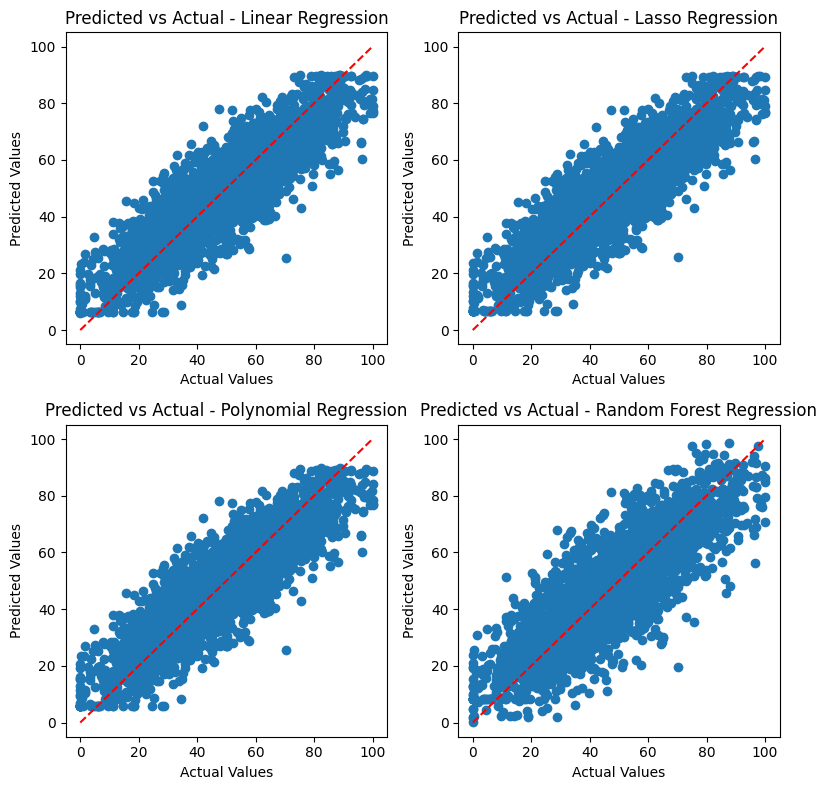

In [146]:
fig,axs = plt.subplots(2,2,figsize=(8,8))

Predicted_Vs_Actual(axs[0,0], y_test, lr_pred, 'Linear Regression')
Predicted_Vs_Actual(axs[0,1], y_test, ls_predict, "Lasso Regression")
Predicted_Vs_Actual(axs[1,0], y_test, y_pred_test, "Polynomial Regression")
Predicted_Vs_Actual(axs[1,1], y_test, rf_pred, "Random Forest Regression")
plt.tight_layout()
plt.show()

**Residuals Plot**

In [147]:
def residual_plot(ax, y_test, y_pred, model_name):

    residuals = y_test - y_pred

    ax.scatter(x=y_pred, y=residuals)
    ax.axhline(0, color='red', linestyle='--')
    ax.set_title("Residuals vs Predicted - "+ model_name, fontsize=8)
    ax.set_xlabel("Predicted Values", fontsize=8)
    ax.set_ylabel("Residuals", fontsize=8)

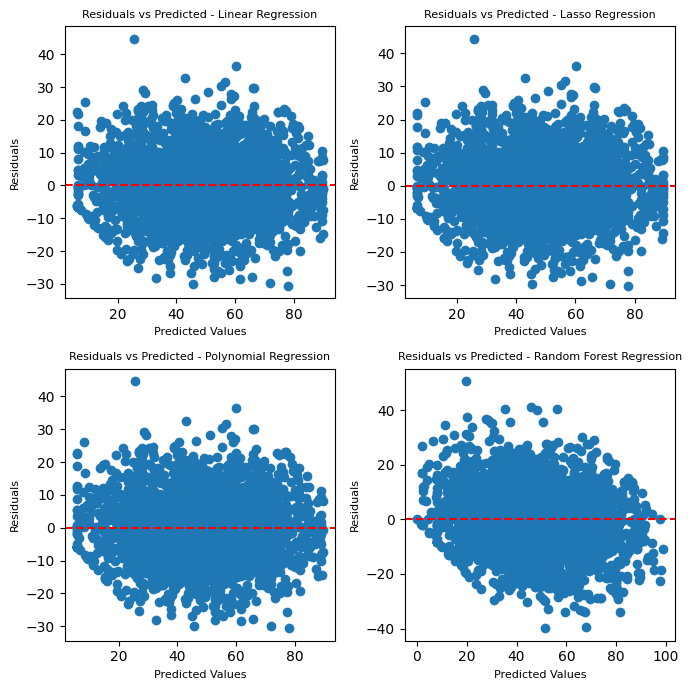

In [148]:
fig, axs = plt.subplots(2, 2, figsize=(7, 7))
residual_plot(axs[0,0], y_test, lr_pred, 'Linear Regression')
residual_plot(axs[0,1], y_test, ls_predict, "Lasso Regression")
residual_plot(axs[1,0], y_test, y_pred_test, "Polynomial Regression")
residual_plot(axs[1,1], y_test, rf_pred, "Random Forest Regression")

plt.tight_layout()
plt.show()